<a href="https://colab.research.google.com/github/leomayer1/multicontrolledgate/blob/main/MultiControlledGate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#necessary if running in Google Colab
%pip install qiskit
%pip install pylatexenc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=2d1d905d48ba62133ebd58e14652ef29d3aabefde19a7014d92de7dd8f236616
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc


In [ ]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, Qubit
from qiskit.quantum_info import Statevector, Operator, random_unitary

from qiskit.circuit.library.standard_gates import HGate, XGate
from qiskit.circuit.library import RYGate, RZGate

import matplotlib.pyplot as plt

import numpy as np

#Z-Y Decomposition

Recall the following single qubit gates:

$R_y(\theta) =
\begin{bmatrix}
  \cos(\frac\theta2) & -\sin(\frac\theta2) \\
  \sin(\frac\theta2) & \cos(\frac\theta2)
\end{bmatrix}$

$R_z(\theta) =
\begin{bmatrix}
  e^{-i\theta/2} & 0 \\
  0 & e^{i\theta/2}
\end{bmatrix}
$

The implementation of multi-controlled gates depends on the fact for any unitary $U$, there exist real numbers $\alpha, \beta, \gamma, \delta$ such that
$U = e^{i\alpha}R_z(\beta)R_y(\gamma)R_z(\delta)$.

In [ ]:
def ZYDecomposition(U):
  w,x,y,z = U[0][0], U[0][1], U[1][0], U[1][1]

  gamma = 2*np.arccos(np.absolute(w))
  a = np.angle(w)
  b = np.angle(y/np.sin(gamma/2))
  c = np.angle(z)
  alpha = (a + c)/2
  beta = b-a
  delta = c-b

  return alpha, beta, gamma, delta

U = random_unitary(2).to_matrix()
alpha, beta, gamma, delta = ZYDecomposition(U)
U2 = np.exp(1j*alpha)*RZGate(beta).to_matrix() @ RYGate(gamma).to_matrix() @ RZGate(delta).to_matrix()

In [ ]:
#lets decompose a random unitary matrix
U = random_unitary(2).to_matrix()
U

array([[-0.43891314-0.12380929j,  0.88093809+0.12639067j],
       [-0.88493037-0.09447088j, -0.45588596+0.01189455j]])

In [ ]:
alpha, beta, gamma, delta = ZYDecomposition(U)
Z1 = RZGate(beta).to_matrix()
Y = RYGate(gamma).to_matrix()
Z2 = RZGate(delta).to_matrix()
U2 = np.exp(1j*alpha)*Z1 @ Y @ Z2
U2

array([[-0.43891314-0.12380929j,  0.88093809+0.12639067j],
       [-0.88493037-0.09447088j, -0.45588596+0.01189455j]])

#Singly-Controlled Gate

Given a single qubit gate $U$, we can implement the controlled version $CU$ by first obtaining $\alpha, \beta, \gamma, \delta$ as above and then noticing that for

$A := R_z(\beta)R_y(\frac\gamma 2)$

$B := R_y(\frac{-\gamma} 2)R_z(\frac{-\delta - \beta} 2)$

$C := R_z(\frac{\delta - \beta}2)$

we have $ABC = I$ and $e^{i\alpha}AXBXC = U$.

In [ ]:
def SingleControlledGate(U):
  alpha, beta, gamma, delta = ZYDecomposition(U)
  A = RZGate(beta).to_matrix() @ RYGate(gamma/2).to_matrix()
  B = RYGate(-gamma/2).to_matrix() @ RZGate(-(delta + beta)/2).to_matrix()
  C = RZGate((delta-beta)/2).to_matrix()

  register = QuantumRegister(2,name="x")
  CU = QuantumCircuit(register, name="Controlled U")
  #apply C
  CU.rz((delta-beta)/2, register[1])
  #apply controlled X
  CU.cx(register[0], register[1])
  #apply B
  CU.rz((-delta-beta)/2, register[1])
  CU.ry(-gamma/2, register[1])
  #apply controlled X
  CU.cx(register[0], register[1])
  #apply A
  CU.ry(gamma/2, register[1])
  CU.rz(beta, register[1])
  CU.p(alpha, register[0])

  return CU

In [ ]:
#let's confirm this implementation works
U = random_unitary(2).to_matrix()
U

array([[-0.41095682-0.0622354j ,  0.90662857+0.07256642j],
       [-0.90167999-0.11922434j, -0.41486867-0.02535236j]])

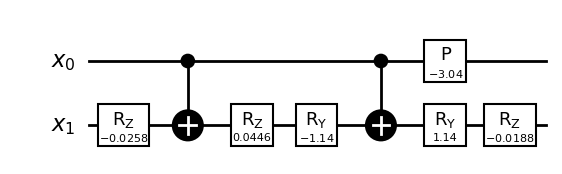

In [ ]:
CU = SingleControlledGate(U)
CU.draw(output="mpl", style="bw")

In [ ]:
np.round(Operator(CU).data, 3)

array([[ 1.   +0.j   ,  0.   +0.j   , -0.   -0.j   ,  0.   +0.j   ],
       [ 0.   +0.j   , -0.411-0.062j,  0.   +0.j   ,  0.907+0.073j],
       [ 0.   -0.j   ,  0.   +0.j   ,  1.   +0.j   ,  0.   +0.j   ],
       [ 0.   +0.j   , -0.902-0.119j,  0.   +0.j   , -0.415-0.025j]])

#Toffoli Gate

The above construction of the singly-controlled gate $CU$ from $U$ can be iterated to obtain the doubly-controlled gate $CCU$. This implemmentation requires a number of single qubit gates which is exponential in the number of control qubits.

More efficient implementations of multi-controlled gates can be built from Toffoli gates and singly-controlled gates.

In [ ]:
#TODO: Implement Toffoli Gate

#Multi-Controlled Gate

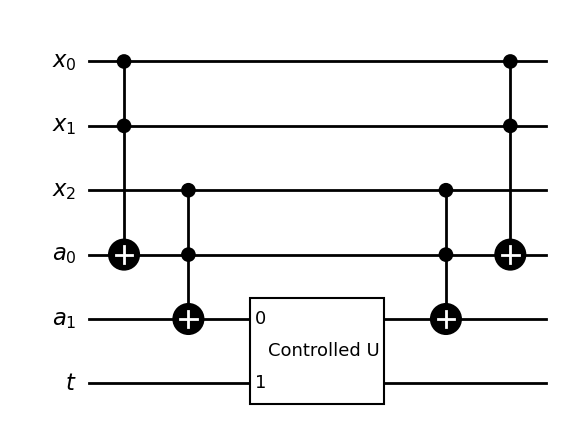

In [ ]:
def MultiControlledGate(n ,U):
  control_register = QuantumRegister(size=n, name="x")
  ancilla_register = AncillaRegister(size=n-1, name="a")
  target_register = QuantumRegister(size=1, name="t")

  #prepares a subroutine which stores the conjunction of all the x[i]s in a[n-2]
  setup = QuantumCircuit(control_register, ancilla_register, name="setup")
  setup.ccx(control_register[0], control_register[1], ancilla_register[0])
  for i in range(2, n):
    setup.ccx(control_register[i], ancilla_register[i-2], ancilla_register[i-1])

  final = QuantumCircuit(control_register, ancilla_register, target_register, name="multicontrolledU")
  final.compose(setup, inplace=True)
  final.append(SingleControlledGate(U).to_gate(), [ancilla_register[n-2], target_register[0]])
  final.compose(setup.inverse(), inplace=True)

  return final

MultiControlledGate(3,U).draw(output="mpl", style="bw")

This method is useful because the number of gates used is linear in the number of control qubits. It is also conceptually very clear: by storing the conjunction of all the control bits in the final ancilla bit, we only need one singly-controlled bit.
The downside is that the number of ancilla qubits used is also linear in the number of control qubits.

There is a clever way of  we give another implementation, in which the number of gates is still linear in the number of control qubits, but now now only two ancilla qubits are used.

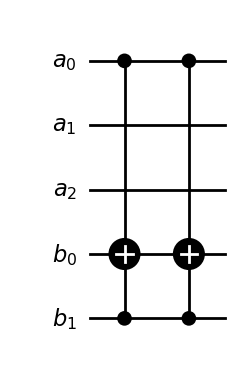

In [ ]:
def Flip_Base():
  a_register = QuantumRegister(size=2)
  b_register = QuantumRegister(size=1)
  F = QuantumCircuit(a_register, b_register)
  F.ccx(a_register[0], a_register[1], b_register[0])
  return F

def Flip(n):
  if n == 2:
    return Flip_Base()
  a_register = QuantumRegister(size=n, name = "a")
  b_register = QuantumRegister(size=n-1, name = "b")
  F = QuantumCircuit(a_register, b_register)
  F.ccx(a_register[0], b_register[1], b_register[0])
  F.compose(Flip(n-1), a_register[1:] + b_register[1:])
  F.ccx(a_register[0], b_register[1], b_register[0])
  return F

Flip(3).draw(output="mpl", style="bw")

In [ ]:
def TestCircuit(n):
  a_register = QuantumRegister(size=n, name = "a")
  circuit = QuantumCircuit(a_register)
  circuit.h(a_register)
  return circuit

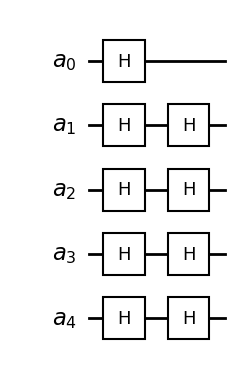

In [ ]:
M = TestCircuit(5)
N = TestCircuit(4)
M.compose(N, M.qubits[1:]).draw(output="mpl", style="bw")